## Preliminaries

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from scipy.stats import percentileofscore as pcnt
import seaborn as sns
from scipy.stats import gaussian_kde
from bokeh import mpl
from bokeh.sampledata import us_counties
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.charts import hplot, Histogram
from bokeh.models import HoverTool
from simpledbf import Dbf5
import matplotlib.pyplot as plt
%matplotlib inline

### Read in data

#### Wisconsin county boundaries are from the Wisconsin Deparment of Natural Resources.  Islands removed to facilitate graphing.  Reprojected using QGIS 2.8.1 into WGS 84-UTM zone 15N.
#### available at <http://www.dnr.state.wi.us/maps/gis/geolibrary.html>


In [2]:
# Read in GIS data
countyxy = pd.read_csv("/home/jared/work/milk_hauling_price/shapes/WI_bnds1.csv")

WI_ ={k:{"X": g["X"].tolist(),"Y":g["Y"].tolist()} for k,g in countyxy.groupby("COUNTY_FIP")}

In [3]:
WI = {WIt: us_counties.data[WIt] for WIt in [x for x in us_counties.data.keys() if x[0]==55 ]}

county_xs=[
    WI_[code]['X'] for code in WI_
]
county_ys=[
    WI_[code]['Y'] for code in WI_
]

#### Read in milk price data collected by (source??)

In [4]:
county_data = Dbf5('/home/jared/work/milk_hauling_price/shapes/WIbnds_simple_stats.dbf', codec='utf-8').to_dataframe().set_index('COUNTY_FIP').fillna(0)
county_data.rename(columns={"MEANHaulin":"hauling_deduction","MEANNetPay":
                            "net_pay","MEANVolume":"volume_premium",
                            "MEANQual_1":"quality_premium",
                            "MEANMarket":"market_premium",
                            "MEANTotalP":"total_premium",
                            "MEANNetPay":"net_pay",
                             "COUNT":'count'}, inplace=True)

### Map and distribution plots

In [168]:
colors = ["#FFFFFF", "#CEDDCC", "#9DBC9A", "#6D9B67", "#3C7A35"]



for var_ in ['total_premium','net_pay','hauling_deduction']:
    ttle  = var_.replace("_"," ").title()
    
    county_colors = []
    county_names = []
    county_value  = []
    county_count  = []
    # Put data in format and assign colors
    for id_ in WI_:
        value = county_data.loc[str(id_)][var_]
        county_value.append(value)
        idx = min(int(pcnt(county_data[var_],value)/20), 4)
        county_colors.append(colors[idx])
        county_names.append(WI[(55,int(id_))]['name'])
        county_count.append(county_data.loc[str(id_)]['count'])

    #county_value = ['N/A' if x==0 else x for x in county_value]

    source = ColumnDataSource(
        data = dict(
            x=county_xs,
            y=county_ys,
            color=county_colors,
            name=county_names,
            value=county_value,
            count=county_count
        )
    )
    
    output_file("WI_"+ttle.replace(" ","")+".html", title= ttle+" Map")
    TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"

    # Make the map object plot
    map_ = figure(title="Average "+ttle+" by County", tools=TOOLS)
    map_.patches('x', 'y',
        fill_color='color', fill_alpha=0.7,    
        line_color="black", line_width=0.5,
        source=source)

    # Make hover tool
    hover = map_.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ("Name", "@name"),
        ("Avg. "+ttle, "$@value{0.00}"),
        ("Sample Size", "@count")
    ])

    # Kernel Density plot
    
    p1 = figure(title=ttle+" Distribution",tools="save,box_zoom,reset")

    hist, edges = np.histogram(county_data[var_], density=True, bins=20)
    gkde=gaussian_kde(county_data[var_])
    ind = np.linspace(0,county_data[var_].max(),101)
    kdepdf = gkde.evaluate(ind)
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
     fill_color="#036564", line_color="#033649")
    p1.line(ind, kdepdf, line_color="#D95B43", line_width=4, alpha=1)

    p = hplot(map_,p1)
    show(p)

### Scatter plot matrix

In [5]:
# Read farm level data

farm_data = pd.read_csv("/home/jared/work/milk_hauling_price/data/combined_data.csv")
cwt_data  = pd.read_csv("/home/jared/work/milk_hauling_price/data/raw_data.csv")[['farmerID','CWT Shipped']]

In [6]:
# Merge premiums with volume shipped.

farm_subdata = farm_data[['FarmerID','VolumePremium','QualityPremium','MarketPremium','TotalPremium','NetPay','HaulingDeduction']]
cwt_data.rename(columns={'CWT Shipped':'volume_cwt'},inplace=True)
farm_subdata.rename(columns={"HaulingDeduction":"hauling_deduction","NetPay":
                            "net_pay","VolumePremium":"volume_premium",
                            "QualityPremium":"quality_premium",
                            "MarketPremium":"market_premium",
                            "TotalPremium":"total_premium","FarmerID":"farmerID"}, inplace=True)
farmdata = farm_subdata.merge(cwt_data,on="farmerID").set_index('farmerID')

/home/jared/anaconda3/envs/py34/lib/python3.4/site-packages/pandas/core/frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [7]:
# Find the percentiles of volume produced

farmdata['volume_cwt'] = farmdata.volume_cwt.astype(np.int64)
farmdata.sort('volume_cwt')
farmdata['cwt_score'] = [int(pcnt(farmdata['volume_cwt'],x)/25) for x in farmdata['volume_cwt']]

farmdata['cwt_percentile'] = [3 if x==4 else x for x in farmdata['cwt_score']]

hue_names = {0:"< 25th",1:"25th-50th",2:"50th-75th",3:"> 75th"}

for i,j in hue_names.items():
    farmdata.ix[farmdata.cwt_percentile==i,'cwt_percentile'] = j
    
pairdata = farmdata[['volume_premium','quality_premium','market_premium','total_premium','cwt_percentile']].rename(columns={'cwt_percentile':'Volume Percentile','volume_premium':'Volume Premium','quality_premium':'Quality Premium','market_premium':'Market Premium','total_premium':'Total Premium'})

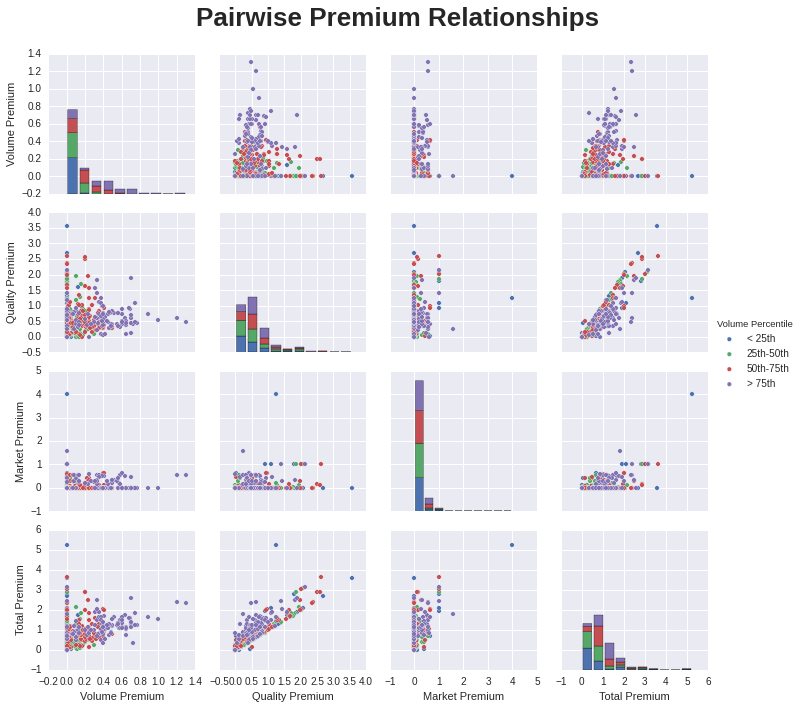

In [161]:
# Make figure
plt.figure(figsize=(12,9))
sct_mat = sns.pairplot(pairdata,hue="Volume Percentile", hue_order=["< 25th","25th-50th","50th-75th","> 75th"])
plt.subplots_adjust(top=.915)

sct_mat.fig.suptitle('Pairwise Premium Relationships', fontsize=26, fontweight='bold')
plt.savefig('premiums_pairwise.png')

### Stacked histogram in Matplotlib

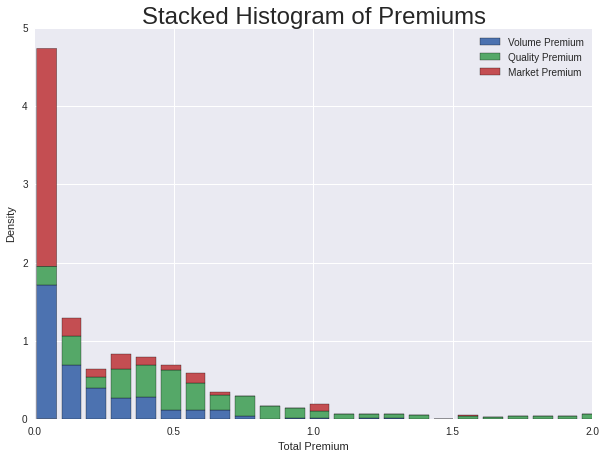

In [20]:
#
fig= plt.figure(figsize=(10,7))
plt.title("Stacked Histogram of Premiums",fontsize=24)
plt.hist([pairdata[(pairdata["Total Premium"]!=0)]['Volume Premium'],
          pairdata[(pairdata["Total Premium"]!=0)]['Quality Premium'],
          pairdata[(pairdata["Total Premium"]!=0)]['Market Premium']],
          bins=45, stacked=True, normed=True)
plt.legend(['Volume Premium','Quality Premium','Market Premium'])
plt.xlim([0,2])
plt.xlabel('Total Premium')
plt.ylabel('Density')
#plt.ylim([0,2.00])
#output_file("premium_hist.html")
#show(mpl.to_bokeh())
plt.savefig('premium_hist_stck.png')

### Using Bokeh

In [21]:
from bokeh.charts import Histogram

output_file("bokeh_stacked_premiums.html")

hist = Histogram([pairdata[(pairdata["Total Premium"]!=0)]['Volume Premium'],
          pairdata[(pairdata["Total Premium"]!=0)]['Quality Premium'],
          pairdata[(pairdata["Total Premium"]!=0)]['Market Premium']],
          bins=40)

show(hist)

# Not stacked but allows interactive zooming

ERROR:/home/jared/anaconda3/envs/py34/lib/python3.4/site-packages/bokeh/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 8db14874-85ad-45dc-9c84-a37d8c1986bf
